In [79]:
# This file is used for cell classification
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix,average_precision_score,precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt


In [80]:

mod1_yang_file = "/home/hqyone/mnt/2tb/github/MaskRCNN_TF1/samples/hpv_models/data/model_pred_results/yang-model-1.tsv"
mod1_yin_file = "/home/hqyone/mnt/2tb/github/MaskRCNN_TF1/samples/hpv_models/data/model_pred_results/yin-model-1.tsv"
mod4_yang_file = "/home/hqyone/mnt/2tb/github/MaskRCNN_TF1/samples/hpv_models/data/model_pred_results/yang-model-4.tsv"
mod4_yin_file = "/home/hqyone/mnt/2tb/github/MaskRCNN_TF1/samples/hpv_models/data/model_pred_results/yin-model-4.tsv"



mod1_yang_df = pd.read_csv(mod1_yang_file, sep='\t')
mod1_yang_df['type']=1
mod1_yin_df = pd.read_csv(mod1_yin_file, sep='\t')
mod1_yin_df['type']=0
mod4_yang_df = pd.read_csv(mod4_yang_file, sep='\t')
mod4_yang_df['type']=1
mod4_yin_df = pd.read_csv(mod4_yin_file, sep='\t')
mod4_yin_df['type']=0

mod1_df = mod1_yang_df.append(mod1_yin_df)
mod4_df = mod4_yang_df.append(mod4_yin_df)

def getXY(df):
    x = df.drop(columns=['patientID','type'], axis=1)
    #x = df.iloc[:,:-1]
    x['yang_ratio']= x['yang']/(x['yang']+x['yin-yang']+x['yin'])
    x['comb_yang']= x['yang']+x['yin-yang']
    x['yang_ratio2']= (x['yang']+x['yin-yang'])/(x['yang']+x['yin-yang']+x['yin'])  
    y = df['type']
    return(x,y)

In [86]:
def plot_pr(recall,precision,average_precision):
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall: {0:0.6f}'.format(average_precision))
    plt.show()
    
def plot_roc(fpr, tpr, roc_auc):
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve (area = %0.6f)' % roc_auc)
    plt.legend(loc="lower right")
    plt.show()


In [125]:
def logisticReg(x, y, seed=72):
    np.random.seed(seed)
    X_train, X_test, y_train, y_test = train_test_split(x, y)
    scaler = StandardScaler()
    lr = LogisticRegression()
    model1 = Pipeline([('standardize', scaler),
                        ('log_reg', lr)])
    model1.fit(X_train, y_train)
    y_train_hat = model1.predict(X_train)
    y_train_hat_probs = model1.predict_proba(X_train)[:,1]

    train_accuracy = accuracy_score(y_train, y_train_hat)*100
    train_auc_roc = roc_auc_score(y_train, y_train_hat_probs)*100

    y_test_hat = model1.predict(X_test)
    y_test_hat_probs = model1.predict_proba(X_test)[:,1]

    test_accuracy = accuracy_score(y_test, y_test_hat)*100
    test_auc_roc = roc_auc_score(y_test, y_test_hat_probs)*100

    y_pred_proba = model1.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

    y_scores = y_pred_proba
    roc_auc = auc(fpr, tpr)
    average_precision = average_precision_score(y_test, y_scores)
    precision, recall, _ = precision_recall_curve(y_test, y_scores)

    plot_roc(fpr, tpr, roc_auc)
    plot_pr(recall,precision,average_precision)

    #create ROC curve
    # plt.plot(fpr,tpr)
    # plt.ylabel('True Positive Rate')
    # plt.xlabel('False Positive Rate')
    # plt.show()

    print('Confusion matrix:\n', confusion_matrix(y_train, y_train_hat))
    print('Training AUC: %.4f %%' % train_auc_roc)
    print('Training accuracy: %.4f %%' % train_accuracy)

    print('Test Confusion matrix:\n', confusion_matrix(y_test, y_test_hat))
    print('Test Training AUC: %.4f %%' % test_auc_roc)
    print('Test Training accuracy: %.4f %%' % test_accuracy)
    print('Average_precision: %.4f ' % float(average_precision))

    return (train_auc_roc, train_accuracy, test_auc_roc, test_accuracy)

In [126]:
from sklearn import svm
def svmReg(x, y, seed=72):
    np.random.seed(seed)
    X_train, X_test, y_train, y_test = train_test_split(x, y)
    svm_regr = svm.LinearSVC()
    svm_regr.fit(X_train, y_train)
    y_train_hat = svm_regr.predict(X_train)
    y_train_hat_probs = svm_regr._predict_proba_lr(X_train)[:,1]

    train_accuracy = accuracy_score(y_train, y_train_hat)*100
    train_auc_roc = roc_auc_score(y_train, y_train_hat_probs)*100

    y_test_hat = svm_regr.predict(X_test)
    y_test_hat_probs = svm_regr._predict_proba_lr(X_test)[:,1]

    test_accuracy = accuracy_score(y_test, y_test_hat)*100
    test_auc_roc = roc_auc_score(y_test, y_test_hat_probs)*100

    y_pred_proba = svm_regr._predict_proba_lr(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

    y_scores = y_pred_proba
    roc_auc = auc(fpr, tpr)
    average_precision = average_precision_score(y_test, y_scores)
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    
    plot_roc(fpr, tpr, roc_auc)
    plot_pr(recall,precision,average_precision)

    #create ROC curve
    # plt.plot(fpr,tpr)
    # plt.ylabel('True Positive Rate')
    # plt.xlabel('False Positive Rate')
    # plt.show()

    print('Confusion matrix:\n', confusion_matrix(y_train, y_train_hat))
    print('Training AUC: %.4f %%' % train_auc_roc)
    print('Training accuracy: %.4f %%' % train_accuracy)

    print('Test Confusion matrix:\n', confusion_matrix(y_test, y_test_hat))
    print('Test Training AUC: %.4f %%' % test_auc_roc)
    print('Test Training accuracy: %.4f %%' % test_accuracy)
    print('Average_precision: %.4f ' % float(average_precision))

    return (train_auc_roc, train_accuracy, test_auc_roc, test_accuracy)

In [127]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc

def RandomForestReg(x, y, seed=72):
    np.random.seed(seed)
    X_train, X_test, y_train, y_test = train_test_split(x, y)

    rfc = RandomForestClassifier(n_estimators=10, random_state=42)
    rfc.fit(X_train, y_train)
    Y_pred = rfc.predict_proba(X_test)
    y_scores = Y_pred[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    average_precision = average_precision_score(y_test, y_scores)
    precision, recall, _ = precision_recall_curve(y_test, y_scores)

    y_train_hat = rfc.predict(X_train)
    y_train_hat_probs = rfc.predict_proba(X_train)[:,1]
    train_accuracy = accuracy_score(y_train, y_train_hat)*100
    train_auc_roc = roc_auc_score(y_train, y_train_hat_probs)*100

    y_test_hat = rfc.predict(X_test)
    y_test_hat_probs = rfc.predict_proba(X_test)[:,1]
    test_accuracy = accuracy_score(y_test, y_test_hat)*100
    test_auc_roc = roc_auc_score(y_test, y_test_hat_probs)*100

    y_pred_proba = rfc.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

    plot_roc(fpr, tpr, roc_auc)
    plot_pr(recall,precision,average_precision)

    print('Confusion matrix:\n', confusion_matrix(y_train, y_train_hat))
    print('Training AUC: %.4f %%' % train_auc_roc)
    print('Training accuracy: %.4f %%' % train_accuracy)

    print('Test Confusion matrix:\n', confusion_matrix(y_test, y_test_hat))
    print('Test Training AUC: %.4f %%' % test_auc_roc)
    print('Test Training accuracy: %.4f %%' % test_accuracy)
    print('Average_precision: %.4f ' % float(average_precision))


No handles with labels found to put in legend.


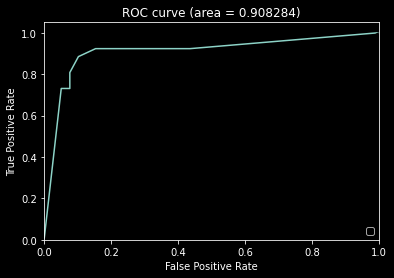

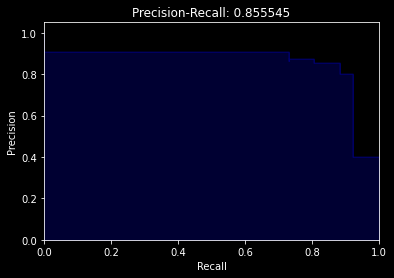

No handles with labels found to put in legend.


Confusion matrix:
 [[98  0]
 [ 2 92]]
Training AUC: 99.9946 %
Training accuracy: 98.9583 %
Test Confusion matrix:
 [[35  4]
 [ 3 23]]
Test Training AUC: 90.8284 %
Test Training accuracy: 89.2308 %
Average_precision: 0.8555 


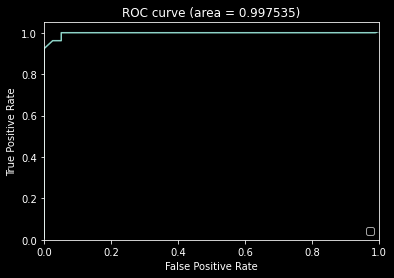

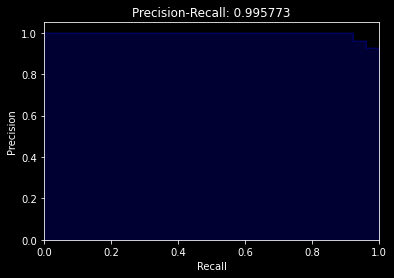

Confusion matrix:
 [[98  0]
 [ 0 94]]
Training AUC: 100.0000 %
Training accuracy: 100.0000 %
Test Confusion matrix:
 [[39  0]
 [ 2 24]]
Test Training AUC: 99.7535 %
Test Training accuracy: 96.9231 %
Average_precision: 0.9958 


In [128]:
def getRandomForestAcc(df, seed=120):
    (x, y) =getXY(df)
    RandomForestReg(x, y,seed)

getRandomForestAcc(mod1_df, seed=200)
getRandomForestAcc(mod4_df, seed=200)

No handles with labels found to put in legend.


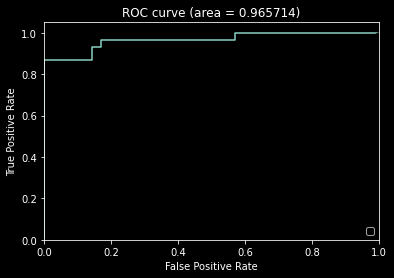

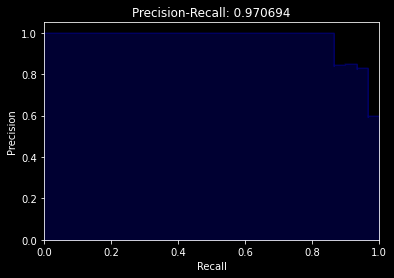

No handles with labels found to put in legend.


Confusion matrix:
 [[99  3]
 [24 66]]
Training AUC: 96.2963 %
Training accuracy: 85.9375 %
Test Confusion matrix:
 [[35  0]
 [ 4 26]]
Test Training AUC: 96.5714 %
Test Training accuracy: 93.8462 %
Average_precision: 0.9707 


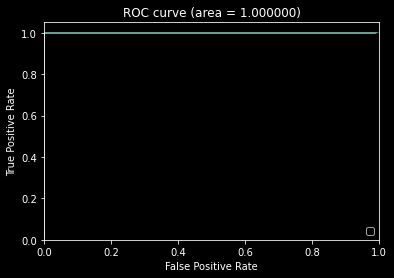

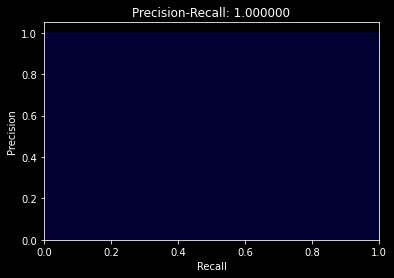

Confusion matrix:
 [[102   0]
 [ 12  78]]
Training AUC: 99.9346 %
Training accuracy: 93.7500 %
Test Confusion matrix:
 [[35  0]
 [ 1 29]]
Test Training AUC: 100.0000 %
Test Training accuracy: 98.4615 %
Average_precision: 1.0000 


In [132]:
def getLogisticAcc(df,seed=72):
    (x, y) =getXY(df)
    logisticReg(x, y,seed)
    
getLogisticAcc(mod1_df, 72)
getLogisticAcc(mod4_df, 72)

/home/hqyone/anaconda3/envs/tf1/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
No handles with labels found to put in legend.


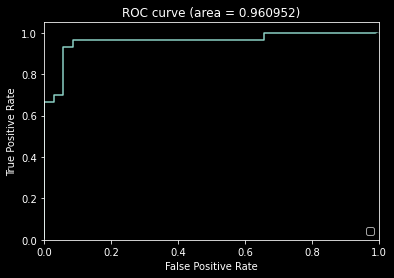

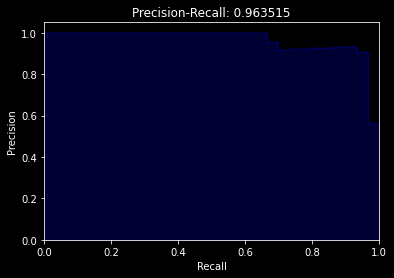

/home/hqyone/anaconda3/envs/tf1/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
No handles with labels found to put in legend.


Confusion matrix:
 [[96  6]
 [13 77]]
Training AUC: 95.8932 %
Training accuracy: 90.1042 %
Test Confusion matrix:
 [[33  2]
 [ 4 26]]
Test Training AUC: 96.0952 %
Test Training accuracy: 90.7692 %
Average_precision: 0.9635 


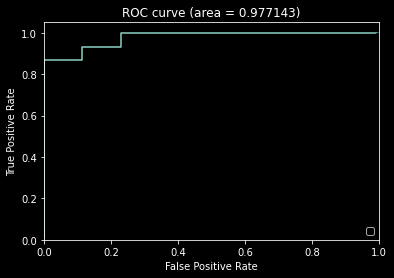

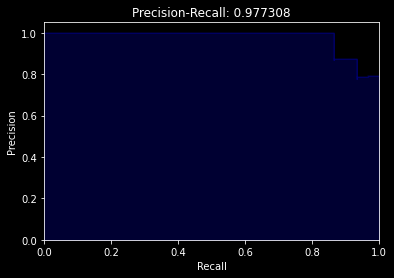

Confusion matrix:
 [[102   0]
 [ 20  70]]
Training AUC: 99.7277 %
Training accuracy: 89.5833 %
Test Confusion matrix:
 [[35  0]
 [ 6 24]]
Test Training AUC: 97.7143 %
Test Training accuracy: 90.7692 %
Average_precision: 0.9773 


In [130]:
def getSVMAcc(mdf,seed=72):
    (x, y) =getXY(mdf)
    svmReg(x, y,seed=seed)

getSVMAcc(mod1_df, seed=45)
getSVMAcc(mod4_df, seed=45)